In [1]:
from __future__ import division
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy as np
from __future__ import (division, print_function,)
import cv2
import os
import skimage.data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from skimage.feature import local_binary_pattern

In [2]:
def generate_segments(im_orig, scale, sigma, min_size):
    """
    Task 1: Segment smallest regions by the algorithm of Felzenswalb.
    1.1. Generate the initial image mask using felzenszwalb algorithm
    1.2. Merge the image mask to the image as a 4th channel
    """
    
    print( scale, sigma, min_size)
    # Apply Felzenszwalb algorithm to generate the segmentation mask
    segments = skimage.segmentation.felzenszwalb(im_orig, scale=scale, sigma=sigma, min_size=min_size)

    # Add the normalized mask as a 4th channel to the original image
    im_orig = np.concatenate((im_orig, segments[:, :, np.newaxis]), axis=2)

    return im_orig

In [3]:
def sim_colour(r1, r2):
    """
    2.1. calculate the sum of histogram intersection of colour
    """
    ### YOUR CODE HERE ###

    return sum([min(x, y) for x, y in zip(r1["color_hist"], r2["color_hist"])])

In [4]:
def sim_texture(r1, r2):
    """
    2.2. calculate the sum of histogram intersection of texture
    """
    ### YOUR CODE HERE ###

    return sum([min(x, y) for x, y in zip(r1["texture_hist"], r2["texture_hist"])])

In [5]:
def sim_size(r1, r2, imsize):
    """
    2.3. calculate the size similarity over the image
    """
    ### YOUR CODE HERE ###

    return 1.0 - (r1['size'] + r2['size']) / imsize

In [6]:
def sim_fill(r1, r2, imsize):
    """
    2.4. calculate the fill similarity over the image
    """
    ### YOUR CODE HERE ###
    
    bbsize = (max(r1['box']['max_x'], r2['box']['max_x']) - min(r1['box']['min_x'], r2['box']['min_x'])) * (max(r1['box']['max_y'], r2['box']['max_y']) - min(r1['box']['min_y'], r2['box']['min_y']))

    return 1.0 - (bbsize - r1['size'] - r2['size']) / imsize

In [7]:
def calc_sim(r1, r2, imsize):
    return (sim_colour(r1, r2) + sim_texture(r1, r2) + sim_size(r1, r2, imsize) + sim_fill(r1, r2, imsize))

In [8]:
def calc_colour_hist(img):
    """
    Task 2.5.1
    calculate colour histogram for each region
    the size of output histogram will be BINS * COLOUR_CHANNELS(3)
    number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
    extract HSV
    """
    BINS = 25
    hist = np.array([])
    ### YOUR CODE HERE ###

    # Calculate the histogram for each channel in HSV
    
    for i in range(3):
        channel = img[:, i].reshape(-1, 1)
        channel_hist = cv2.calcHist([channel], [0], None, [BINS], [0, 256])
        channel_hist = channel_hist.flatten()
        hist = np.concatenate((hist, channel_hist))
#         plt.plot(channel_hist, label=f'Channel {i}')
    
    hist = hist / np.sum(hist)
    
#     plt.legend()
#     plt.xlabel('Bins')
#     plt.ylabel('Frequency')
#     plt.title('HSV Color Histogram')
#     plt.show()
    
    return hist

In [9]:
def calc_texture_gradient(img):
    """
    Task 2.5.2
    calculate texture gradient for entire image
    The original SelectiveSearch algorithm proposed Gaussian derivative
    for 8 orientations, but we will use LBP instead.
    output will be [height(*)][width(*)]
    Useful function: Refer to skimage.feature.local_binary_pattern documentation
    """
    if len(img.shape) == 2:
        img = img.reshape(img.shape[0], img.shape[1], 1)
    channel_nums = img.shape[2]


    lbp_img = np.zeros(img.shape)
    for channel in range(channel_nums):
        layer = img[:, :, channel]
        lbp_img[:, :, channel] = local_binary_pattern(layer, 8, 1)
        

    return lbp_img

In [10]:
def calc_texture_hist(img):
    """
    Task 2.5.3
    calculate texture histogram for each region
    calculate the histogram of gradient for each colours
    the size of output histogram will be
        BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    Do not forget to L1 Normalize the histogram
    """
    BINS = 10    
    hist = np.array([])
    if img.dtype != np.uint8 and img.dtype != np.float32:
        img = img.astype(np.float32)

    for i in range(3):
        channel = img[:, i].reshape(-1, 1)
        channel_hist = cv2.calcHist([channel], [0], None, [BINS], [0, 256])
        channel_hist = channel_hist.flatten()
        hist = np.concatenate((hist, channel_hist))
#         plt.plot(channel_hist, label=f'Channel {i}')

    # L1 normalize
    hist = hist / np.sum(hist)
    
#     plt.legend()
#     plt.xlabel('Bins')
#     plt.ylabel('Frequency')
#     plt.title('texture hist')
#     plt.show()

    return hist

In [11]:
def extract_regions(img):
    '''
    Task 2.5: Generate regions denoted as datastructure R
    - Convert image to hsv color map
    - Count pixel positions
    - Calculate the texture gradient
    - calculate color and texture histograms
    - Store all the necessary values in R.
    '''
    R = {}
    ### YOUR CODE HERE ###
    
    rgb_image = img[:, :, :3]
    rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
    hsv_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HSV)
    print("HSV Image Shape",hsv_img.shape)
    
    segment_labels = img[:, :, 3]
    segment_positions = {}
    
    for i in range(segment_labels.shape[0]):
        for j in range(segment_labels.shape[1]):
            segment_label = segment_labels[i, j]
            
            if segment_label not in segment_positions:
                segment_positions[segment_label] = []
            segment_positions[segment_label].append((i, j))
                 
                
    texture_gradient = calc_texture_gradient(hsv_img)
    print("Texture_gradient shape",texture_gradient.shape)
    
    segment_color_histograms = {}
    segment_texture_histograms = {}
    segment = 0
    total_size = 0
    
    for segment_label, positions in segment_positions.items():
        # Extracting pixels belonging to the current segment
        segment_pixels = np.array([hsv_img[x, y] for x, y in positions])
        color_hist = calc_colour_hist(segment_pixels)
        
        segment_pixels = np.array([texture_gradient[x, y] for x, y in positions])
        texture_hist = calc_texture_hist(segment_pixels)
        
        size = len(positions)
        
        min_x, min_y = positions[0]
        max_x, max_y = positions[0]

        # Iterate over all positions to find the min and max coordinates
        for x, y in positions:
            min_x = min(min_x, x)
            min_y = min(min_y, y)
            max_x = max(max_x, x)
            max_y = max(max_y, y)
        
        box = {'min_x':min_x,
               'min_y':min_y, 
               'max_x':max_x,
               'max_y':max_y }
        
        
        R[segment_label] = {
            'size': size,
            'box': box,
            'color_hist': color_hist,
            'texture_hist': texture_hist
        }
        

    return R

In [12]:
def extract_neighbours(regions, region_num):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    # Hint 1: List of neighbouring regions
    # Hint 2: The function intersect has been written for you and is required to check neighbours
    
    if(region_num == 0):
        neighbours = []
        ### YOUR CODE HERE ###

        region_labels = list(regions.keys())

        for i in range(len(region_labels)):
            for j in range(i + 1, len(region_labels)):
                region1_label = region_labels[i]
                region2_label = region_labels[j]
                region1 = regions[region1_label]
                region2 = regions[region2_label]
                
                if(intersect(region1['box'], region2['box'])):
                    neighbours.append(((region1_label, region1), (region2_label, region2)))
                    

    if(region_num>0):
        neighbours = []
        region_labels = list(regions.keys())
        for i in range(len(region_labels) - 1):
            region1_label = region_num
            region2_label = region_labels[i]
            region1 = regions[region1_label]
            region2 = regions[region2_label]
            
            if(intersect(region1['box'], region2['box'])):
                neighbours.append(((region1_label, region1), (region2_label, region2)))
              
    return neighbours

In [13]:
def merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {}
    ### YOUR CODE HERE
    
    new_box = {'min_x': min(r1['box']['min_x'], r2['box']['min_x']),
               'min_y': min(r1['box']['min_y'], r2['box']['min_y']),
               'max_x': max(r1['box']['max_x'], r2['box']['max_x']),
               'max_y': max(r1['box']['max_y'], r2['box']['max_y']) }    
    
    rt = {
        'box': new_box,
        'size': new_size,
        'color_hist':(r1['color_hist'] * r1['size'] + r2['color_hist'] * r2['size']) / new_size,
        'texture_hist':(r1['texture_hist'] * r1['size'] + r2['texture_hist'] * r2['size']) / new_size,
    }

    return rt

In [14]:
def selective_search(image_orig, scale=1.0, sigma=0.8, min_size=50):
    '''
    Selective Search for Object Recognition" by J.R.R. Uijlings et al.
    :arg:
        image_orig: np.ndarray, Input image
        scale: int, determines the cluster size in felzenszwalb segmentation
        sigma: float, width of Gaussian kernel for felzenszwalb segmentation
        min_size: int, minimum component size for felzenszwalb segmentation

    :return:
        image: np.ndarray,
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions: array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                    
                },
                ...
            ]
    '''

    # Checking the 3 channel of input image
    assert image_orig.shape[2] == 3, "Please use image with three channels."
    imsize = image_orig.shape[0] * image_orig.shape[1]
    
    # Task 1: Load image and get smallest regions. Refer to `generate_segments` function.
    image = generate_segments(image_orig, scale, sigma, min_size)
    print("Maskted Image Shape",image.shape)
    

    if image is None:
        return None, {}

    # Task 2: Extracting regions from image
    # Task 2.1-2.4: Refer to functions "sim_colour", "sim_texture", "sim_size", "sim_fill"
    # Task 2.5: Refer to function "extract_regions". You would also need to fill "calc_colour_hist",
    # "calc_texture_hist" and "calc_texture_gradient" in order to finish task 2.5.
    R = extract_regions(image)
    
    temp_R =R.copy()

    # Task 3: Extracting neighbouring information
    # Refer to function "extract_neighbours"
    neighbours = extract_neighbours(R, 0)

    # Calculating initial similarities
    S = {}
    
    for (ai, ar), (bi, br) in (neighbours):
        S[(ai, bi)] = calc_sim(ar, br, imsize)
        
     # Hierarchical search for merging similar regions
    while S != {}:

        # Get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # Task 4: Merge corresponding regions. Refer to function "merge_regions"
        t = max(R.keys()) + 1
        
        R[t] = merge_regions(R[i], R[j])
        temp_R[t] = R[t]

        # Task 5: Mark similarities for regions to be removed
        ### YOUR CODE HERE ###
       
        similarities_to_remove = []
        for key in S.keys():
            if(i in key) or (j in key):
                similarities_to_remove.append(key)
                
        # Task 6: Remove old similarities of related regions
        ### YOUR CODE HERE ###
        del temp_R[i]
        del temp_R[j]
        
        for key in similarities_to_remove:
            del S[key]
            
        # Task 7: Calculate similarities with the new region
        ### YOUR CODE HERE ###
        neighbours = extract_neighbours(temp_R, t)
        
        for (ai, ar), (bi, br) in (neighbours):
            S[(ai, bi)] = calc_sim(ar, br, imsize)
            

    # Task 8: Generating the final regions from R
    regions = []
    ### YOUR CODE HERE ###
    regions = R

    return image, regions

In [31]:
def main():
    
    # loading a test image from '../data' folder
    image_path = 'data/classarch/pursuit2.jpg'
    image = skimage.io.imread(image_path)
    print (image.shape)
    
    # perform selective search
    image_label, regions = selective_search(image, scale=500, min_size=20)
    
    candidates = set()
    for r in regions.keys():

        # excluding same rectangle (with different segments)
        box_as_tuple = (regions[r]['box']['min_y'], regions[r]['box']['min_x'], regions[r]['box']['max_y'] - regions[r]['box']['min_y'],regions[r]['box']['max_x'] -  regions[r]['box']['min_x'])
        if box_as_tuple in candidates:
            continue
        
        # excluding regions smaller than 2000 pixels
        # you can experiment using different values for the same
        if regions[r]['size'] < 2000:
            continue
        
        # excluding distorted rects
        x, y, w, h = box_as_tuple
        if w/h > 1.2 or h/w > 1.2:
            continue
        
        candidates.add(box_as_tuple)
        
    # Draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image)
    for x, y, w, h in candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1
        )
        ax.add_patch(rect)
    plt.axis('off')
    # saving the image
    if not os.path.isdir('results/'):
        os.makedirs('results/')
    fig.savefig('results/'+image_path.split('/')[-1])
    plt.show()

(659, 1000, 3)
500 0.8 20
Maskted Image Shape (659, 1000, 4)
HSV Image Shape (659, 1000, 3)
Texture_gradient shape (659, 1000, 3)


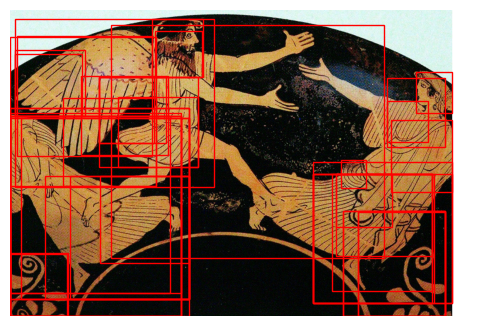

In [32]:
if __name__ == '__main__':
    main()